In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

def download(split_range, shuffle=False):
    ds = tfds.load(
        name="mnist",
        split=f"train[{split_range}]",
        as_supervised=True,
        shuffle_files=True,
    ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    if shuffle:
        ds = ds.shuffle(10, reshuffle_each_iteration=True)
    return ds.batch(128).prefetch(1)


train_data_loader, val_data_loader, test_data_loader = (
    download(":80%", shuffle=True),
    download("80%:90%"),
    download("90%:"),
)

In [10]:
from fortuna.data import DataLoader

train_data_loader = DataLoader.from_tensorflow_data_loader(train_data_loader)
val_data_loader = DataLoader.from_tensorflow_data_loader(val_data_loader)
test_data_loader = DataLoader.from_tensorflow_data_loader(test_data_loader)

In [13]:
from fortuna.prob_model import MAPPosteriorApproximator
from fortuna.prob_model import FitConfig, FitMonitor, FitOptimizer
from fortuna.metric.classification import accuracy
from fortuna.prob_model import ProbClassifier
from fortuna.model import LeNet5

prob_model = ProbClassifier(
    model=LeNet5(output_dim=10),
    posterior_approximator=MAPPosteriorApproximator(),
    output_calibrator=None,
)
status = prob_model.train(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    calib_data_loader=val_data_loader,
    fit_config=FitConfig(
        monitor=FitMonitor(metrics=(accuracy,)),
        optimizer=FitOptimizer(n_epochs=1),
    ),
)

Epoch: 1 | loss: 46000.58984 | accuracy: 0.96875: 100%|██████████| 1/1 [00:22<00:00, 22.97s/it]


ECE: 0.013216117396950722.


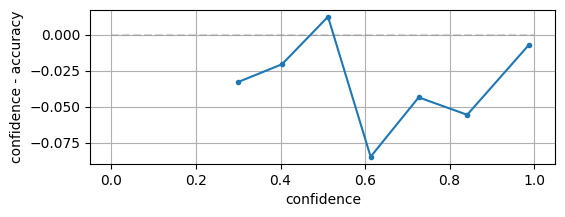

In [14]:
test_inputs_loader = test_data_loader.to_inputs_loader()
test_targets = test_data_loader.to_array_targets()
preds = prob_model.predictive.mode(test_inputs_loader)
probs = prob_model.predictive.mean(test_inputs_loader)

from fortuna.metric.classification import expected_calibration_error

ece = expected_calibration_error(
    preds, probs, test_targets, plot=True, plot_options=dict(figsize=(6, 2))
)
print(f"ECE: {ece}.")

In [15]:
preds

Array([8, 4, 0, ..., 6, 1, 5], dtype=int32)

In [16]:
probs

Array([[2.94498332e-05, 8.94656580e-08, 1.02104328e-04, ...,
        1.22210281e-06, 9.96726513e-01, 5.00258830e-05],
       [1.68653496e-03, 3.35631007e-03, 1.16352516e-03, ...,
        5.40736364e-03, 2.98090130e-02, 5.68192219e-03],
       [9.98846233e-01, 4.34215224e-08, 5.36583939e-05, ...,
        2.82441779e-05, 6.52679091e-07, 1.05919340e-03],
       ...,
       [7.27240369e-03, 9.93274807e-05, 1.10496017e-04, ...,
        2.44300736e-06, 2.82114740e-07, 1.75082235e-07],
       [3.89702109e-07, 9.99420166e-01, 1.34063885e-05, ...,
        1.80240604e-04, 1.33121575e-05, 8.19092566e-06],
       [8.47135391e-03, 9.70895417e-06, 4.55992404e-06, ...,
        1.63910910e-03, 1.25688529e-02, 9.64165258e-04]], dtype=float32)

In [ ]:
from fortuna.calib_model import CalibClassifier

calib_model = CalibClassifier(model=LeNet5(output_dim=10))

In [3]:
from fortuna.calib_model import Config, Monitor
from fortuna.metric.classification import brier_score, accuracy


def brier(preds, uncertainties, targets):
    return brier_score(uncertainties, targets)


def acc(preds, uncertainties, targets):
    return accuracy(preds, targets)


status = calib_model.calibrate(
    train_data_loader,
    val_data_loader=val_data_loader,
    config=Config(monitor=Monitor(early_stopping_patience=2, metrics=(brier, acc))),
)

Epoch: 6 | loss: 0.0267 | brier: 0.02945 | acc: 0.97656:   5%|▌         | 5/100 [01:56<36:54, 23.31s/it] 


In [4]:
test_inputs_loader = test_data_loader.to_inputs_loader()
preds = calib_model.predictive.mode(test_inputs_loader)
probs = calib_model.predictive.mean(test_inputs_loader)

ECE: 0.006157419644296169.


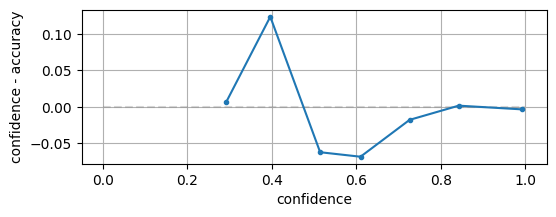

In [5]:
from fortuna.metric.classification import expected_calibration_error

test_targets = test_data_loader.to_array_targets()
ece = expected_calibration_error(
    preds, probs, test_targets, plot=True, plot_options=dict(figsize=(6, 2))
)
print(f"ECE: {ece}.")